<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Doggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"
!kaggle competitions download dog-breed-identification
!unzip "/content/dog-breed-identification"

In [ ]:
!pip install --upgrade fastai
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
from fastai import *

In [3]:
labels = pd.read_csv('/content/labels.csv')
def label_func(fname):
    return labels.loc[labels.id == fname.name[:-4], 'breed'].item()

path = Path('/content/train/')

In [ ]:
labels.groupby('breed').size().nsmallest(10)

breed
briard               66
eskimo_dog           66
brabancon_griffon    67
golden_retriever     67
komondor             67
german_shepherd      69
giant_schnauzer      69
otterhound           69
tibetan_mastiff      69
walker_hound         69
dtype: int64

In [4]:
import random
removed_samples = random.sample(path.ls(), 7000)
for doggie in removed_samples:
    doggie.unlink()

In [5]:
path.ls()

(#3222) [Path('/content/train/9527fc067fec743019a444465358c23e.jpg'),Path('/content/train/35e495b1de348a81e9c64f929de8beff.jpg'),Path('/content/train/359a64c4efe3a9b90ecb399934a06439.jpg'),Path('/content/train/770e93c5d9961cc0b72dc41069cdaa62.jpg'),Path('/content/train/aeb846fd220051321d1295eb7388fe23.jpg'),Path('/content/train/51e9a9481ffe34499d6b251031516a85.jpg'),Path('/content/train/8fb29d378d44d3f4af216cf4912ed789.jpg'),Path('/content/train/9e03036e569f2a305e264b97c1aaab84.jpg'),Path('/content/train/d8488f933f021216d7a39f6e8f1bc9c5.jpg'),Path('/content/train/553ba861e419597a38c9fb9c5237567f.jpg')...]

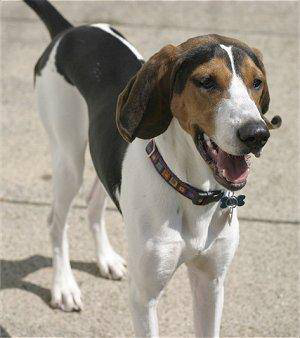

In [ ]:
Image.open(path.ls()[1002])

In [37]:
timg = TensorImage(array(Image.open(path.ls()[1002]))).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

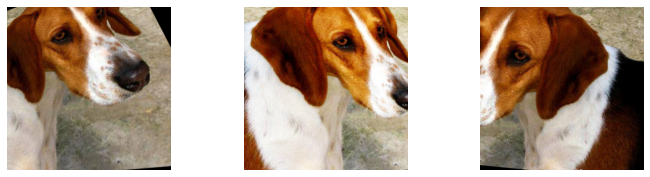

In [39]:
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.5)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [34]:
tfms

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'zeros', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': None, 'min_scale': 0.5, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [6]:
def get_dls(bs, size):
    dogs = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
                    get_y = label_func,
                    item_tfms = Resize(460),
                    batch_tfms = aug_transforms(size=size, min_scale=0.75))
    return dogs.dataloaders(path, bs=bs)

dls = get_dls(64, 224)
#dls = dogs.dataloaders(temp_path, batch_size = 150)
#batch_tfms = aug_transforms(size=224, mult=2, min_scale=0.5))

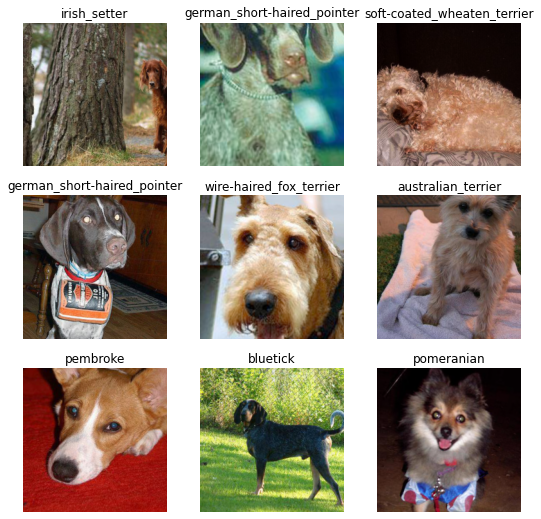

In [7]:
dls.train.show_batch()

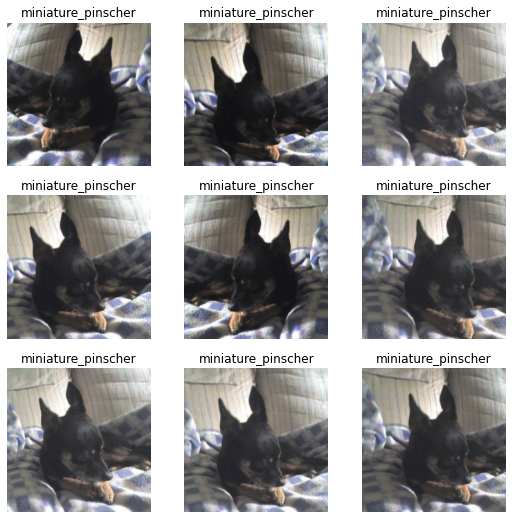

In [8]:
dls.train.show_batch(unique= True)

In [11]:
#First try
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(12, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.313458,1.003622,0.720497,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.969159,0.762144,0.771739,00:31
1,0.749632,0.822741,0.784162,00:31
2,0.695452,1.052403,0.728261,00:31
3,0.663609,1.066216,0.723602,00:31
4,0.563094,1.135141,0.706522,00:31
5,0.436258,1.091071,0.737578,00:31
6,0.322360,1.068600,0.726708,00:31
7,0.217494,0.973124,0.753106,00:31
8,0.151738,0.919154,0.773292,00:31
9,0.105285,0.904217,0.765528,00:31


In [12]:
#Second try
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.604020,1.088230,0.697205,00:30
1,1.916147,0.993061,0.729814,00:30
2,1.217601,0.812933,0.763975,00:30
3,0.799828,0.758873,0.770186,00:30
4,0.549444,0.702223,0.801242,00:30
5,0.396745,0.680712,0.795031,00:30


SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=1.9054607491852948e-06)

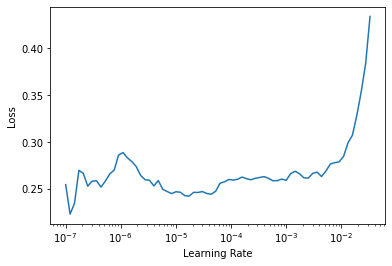

In [13]:
learn.lr_find()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(6, lr_max = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.272228,0.691818,0.787267,00:31
1,0.312595,0.945529,0.759317,00:31
2,0.288556,0.901467,0.760870,00:31
3,0.247946,0.792813,0.777950,00:31
4,0.198757,0.761960,0.777950,00:31
5,0.152316,0.755238,0.779503,00:31


In [15]:
# Third try
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.853499,2.043650,0.507764,00:27
1,3.091234,1.409603,0.618012,00:27
2,2.171091,1.199522,0.695652,00:27
3,1.632111,1.125943,0.703416,00:27
4,1.260442,1.091467,0.709627,00:27
5,1.015114,1.077772,0.709627,00:27


SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=7.585775847473997e-07)

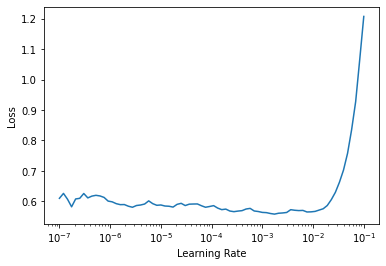

In [16]:
learn.lr_find()

In [21]:
learn.dls = get_dls(64, 224)
learn.fit_one_cycle(6, lr_max = slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.640290,0.690903,0.785714,00:30
1,0.584454,0.667759,0.799689,00:30
2,0.537518,0.645422,0.795031,00:30
3,0.472437,0.639710,0.787267,00:30
4,0.423734,0.620349,0.795031,00:30
5,0.391124,0.615992,0.799689,00:30


In [22]:
interp = ClassificationInterpretation.from_learner(learn)

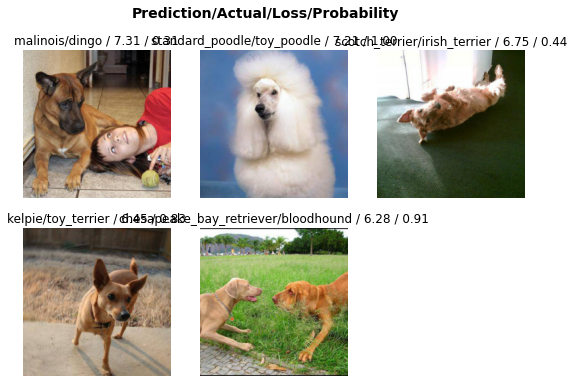

In [23]:
interp.plot_top_losses(5)

In [25]:
losses = interp.most_confused()
losses

[('shetland_sheepdog', 'collie', 7),
 ('cocker_spaniel', 'english_springer', 3),
 ('lhasa', 'maltese_dog', 3),
 ('siberian_husky', 'malamute', 3),
 ('wire-haired_fox_terrier', 'lakeland_terrier', 3),
 ('appenzeller', 'bernese_mountain_dog', 2),
 ('brittany_spaniel', 'english_springer', 2),
 ('cairn', 'australian_terrier', 2),
 ('chihuahua', 'toy_terrier', 2),
 ('german_shepherd', 'malinois', 2),
 ('labrador_retriever', 'flat-coated_retriever', 2),
 ('shih-tzu', 'lhasa', 2),
 ('silky_terrier', 'australian_terrier', 2),
 ('toy_poodle', 'miniature_poodle', 2),
 ('yorkshire_terrier', 'silky_terrier', 2),
 ('afghan_hound', 'saluki', 1),
 ('airedale', 'lakeland_terrier', 1),
 ('american_staffordshire_terrier', 'clumber', 1),
 ('american_staffordshire_terrier', 'staffordshire_bullterrier', 1),
 ('appenzeller', 'entlebucher', 1),
 ('appenzeller', 'rottweiler', 1),
 ('australian_terrier', 'silky_terrier', 1),
 ('basenji', 'appenzeller', 1),
 ('bloodhound', 'chesapeake_bay_retriever', 1),
 ('blu

In [ ]:
pd.Series([x[0] for x in losses], name = 'Incorrect').value_counts().head(10)

standard_poodle                   5
norfolk_terrier                   5
american_staffordshire_terrier    5
wire-haired_fox_terrier           4
golden_retriever                  4
german_shepherd                   4
english_foxhound                  4
rottweiler                        4
lhasa                             4
otterhound                        4
Name: Incorrect, dtype: int64

In [ ]:
labels.loc[labels.breed == 'standard_poodle']

,id,breed
274,068314c65cbe67fa4f57283f4f3a801c,standard_poodle
523,0cb5839c82f7c1286e55f260d4e608c4,standard_poodle
601,0eb00c6fc429ecc2cf8745a6334594ad,standard_poodle
899,160160c8ac562966448486906cb56308,standard_poodle
1086,1ae80c7e781d72681bc8e582a703919d,standard_poodle
...,...,...
9477,ed9c22ad21413691f548f5d72e7a76d9,standard_poodle
9541,ef22e67b6d82c04f2d17249e42769d35,standard_poodle
9663,f33c92eca07a03a242b4a9986fc66d9b,standard_poodle
9690,f3cf90e3a8a78d31850eca467122183a,standard_poodle


In [ ]:
test_path = Path('/content/test/')
tst_files = get_image_files(test_path)
tst_dl = dls.test_dl(tst_files)

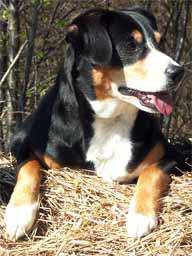

In [ ]:
Image.open(test_path.ls()[1])

In [ ]:
learn.dls.vocab[42]

'entlebucher'

In [ ]:
predictions = learn.get_preds(dl = tst_dl)[0]

In [ ]:
predictions = learn.tta(dl = tst_dl)[0]

KeyboardInterrupt: ignored

In [ ]:
predictions

In [ ]:
tmp = predictions

In [ ]:
actual_preds = torch.argmax(predictions, axis=1)
actual_preds

tensor([10, 42, 89,  ...,  1, 65, 34])

In [ ]:
predictions[range(len(predictions)), actual_preds] = 1
actual_predictions = predictions.masked_fill(predictions != 1, 0)

In [ ]:
sub = pd.DataFrame(predictions.numpy())
sub.columns = learn.dls.vocab
sub.insert(0, column = 'id', value = [x.name[:-4] for x in test_path.ls()])

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -f /content/submission.csv -m something dog-breed-identification

100% 16.4M/16.4M [00:00<00:00, 28.5MB/s]
Successfully submitted to Dog Breed Identification

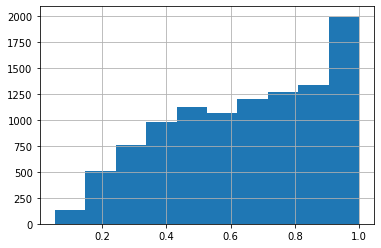

In [ ]:
import matplotlib.pyplot as plt
sub.max(axis = 1).hist()